<a href="https://colab.research.google.com/github/mjevans26/GEE/blob/master/ManasDNNClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN Land Cover Classification

This is a Notebook demonstrating GEE and Tensorflow code to train a deep neural network classifier that can predict land cover classes in Manas National Park, India based on Sentinel-2 data.

@author Michael Evans

In [ ]:
# !pip install earthengine-api --upgrade

In [ ]:
!pip install rasterio


In [ ]:
from google.colab import auth, drive
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import metrics
import rasterio as rio
import json
from os.path import join, basename
import folium
from datetime import datetime
from sklearn.utils import compute_class_weight
import matplotlib as plt

In [ ]:
# Cloud authentication.
auth.authenticate_user()

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=BpHS5jvotRMGzWuXYojWxj3-lU9js0da6BlGEI9Swek&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7eyMvQfsfGgF43D64rMby3ev-adax9oejSPnMK96OwDyxWdVlhGMA

Successfully saved authorization token.


In [ ]:
# mount google drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
RESPONSE = 'class_num'

BANDS = [[band, band + '_1', band + '_2', band + '_3'] for band in bands]
FEATURES = [item for sublist in BANDS for item in sublist] + [RESPONSE]

KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
PATCH_SIZE = KERNEL_SIZE**2

COLUMNS = [tf.io.FixedLenFeature(shape = [1], dtype = tf.float32) for feature in FEATURES]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

BATCH = 16
BUFFER = 500

## GEE

### Assets

In [ ]:
# Bring in GEE Assets
geometry = ee.Geometry.Polygon(
        [[[90.82344697523781, 26.738600672068177],
          [90.82344697523781, 26.673580632363688],
          [90.93262361098, 26.673580632363688],
          [90.93262361098, 26.738600672068177]]], None, False)

S2 = ee.ImageCollection("COPERNICUS/S2")
boundary = ee.FeatureCollection("users/defendersofwildlifeGIS/Manas/park_boundary")
table = ee.FeatureCollection("users/defendersofwildlifeGIS/Manas/WWF_groundtruth")
water19 = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([90.97610822107781, 26.719111197026088]),
            {
              "class": "River / water",
              "system:index": "0"
            }),
        ee.Feature(
            ee.Geometry.Point([90.96907010462273, 26.721066158480355]),
            {
              "class": "River / water",
              "system:index": "1"
            }),
        ee.Feature(
            ee.Geometry.Point([90.98254552271355, 26.676093553006698]),
            {
              "class": "River / water",
              "system:index": "2"
            }),
        ee.Feature(
            ee.Geometry.Point([90.97653737452019, 26.66021663154497]),
            {
              "class": "River / water",
              "system:index": "3"
            }),
        ee.Feature(
            ee.Geometry.Point([90.66302329393157, 26.769465871927885]),
            {
              "class": "River / water",
              "system:index": "4"
            }),
        ee.Feature(
            ee.Geometry.Point([90.66699296327361, 26.77122839121633]),
            {
              "class": "River / water",
              "system:index": "5"
            }),
        ee.Feature(
            ee.Geometry.Point([90.95303411239483, 26.775168139072722]),
            {
              "class": "River / water",
              "system:index": "6"
            }),
        ee.Feature(
            ee.Geometry.Point([90.95559316153376, 26.78053850572255]),
            {
              "class": "River / water",
              "system:index": "7"
            }),
        ee.Feature(
            ee.Geometry.Point([91.0800661572924, 26.68540031781873]),
            {
              "class": "River / water",
              "system:index": "8"
            })])
riverbed19 = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([90.97505232717339, 26.72105388768015]),
            {
              "class": "Dry river bed",
              "system:index": "0"
            }),
        ee.Feature(
            ee.Geometry.Point([90.97530981923882, 26.715035564941704]),
            {
              "class": "Dry river bed",
              "system:index": "1"
            }),
        ee.Feature(
            ee.Geometry.Point([90.97513815786186, 26.698857349935267]),
            {
              "class": "Dry river bed",
              "system:index": "2"
            }),
        ee.Feature(
            ee.Geometry.Point([90.95252177144829, 26.703611376662145]),
            {
              "class": "Dry river bed",
              "system:index": "3"
            }),
        ee.Feature(
            ee.Geometry.Point([90.92436930562798, 26.71009033553118]),
            {
              "class": "Dry river bed",
              "system:index": "4"
            }),
        ee.Feature(
            ee.Geometry.Point([90.91574332143608, 26.691035777533756]),
            {
              "class": "Dry river bed",
              "system:index": "5"
            }),
        ee.Feature(
            ee.Geometry.Point([91.22661218931935, 26.773018331221962]),
            {
              "class": "Dry river bed",
              "system:index": "6"
            }),
        ee.Feature(
            ee.Geometry.Point([91.20047345374232, 26.77678705224535]),
            {
              "class": "Dry river bed",
              "system:index": "7"
            }),
        ee.Feature(
            ee.Geometry.Point([91.13175377810566, 26.7825129618336]),
            {
              "class": "Dry river bed",
              "system:index": "8"
            }),
        ee.Feature(
            ee.Geometry.Point([91.15449891055195, 26.785539532470434]),
            {
              "class": "Dry river bed",
              "system:index": "9"
            }),
        ee.Feature(
            ee.Geometry.Point([91.09807698821152, 26.754099312113876]),
            {
              "class": "Dry river bed",
              "system:index": "10"
            }),
        ee.Feature(
            ee.Geometry.Point([91.10462157820785, 26.74898332790459]),
            {
              "class": "Dry river bed",
              "system:index": "11"
            })])
table2 = ee.FeatureCollection("users/defendersofwildlifeGIS/Manas/WWF_groundtruth_20Dec")
ag = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([91.18078623464676, 26.749444432737576]),
            {
              "class": "Agriculture",
              "system:index": "0"
            }),
        ee.Feature(
            ee.Geometry.Point([91.15618707005231, 26.739280869175335]),
            {
              "class": "Agriculture",
              "system:index": "1"
            }),
        ee.Feature(
            ee.Geometry.Point([91.150908482711, 26.72737998889601]),
            {
              "class": "Agriculture",
              "system:index": "2"
            }),
        ee.Feature(
            ee.Geometry.Point([90.70278475804807, 26.64348089177791]),
            {
              "class": "Agriculture",
              "system:index": "3"
            }),
        ee.Feature(
            ee.Geometry.Point([90.69175551457883, 26.642368494404526]),
            {
              "class": "Agriculture",
              "system:index": "4"
            }),
        ee.Feature(
            ee.Geometry.Point([90.67105341466294, 26.643900229785938]),
            {
              "class": "Agriculture",
              "system:index": "5"
            })])
water18 = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([90.97494708705473, 26.691109242382723]),
            {
              "class": "River / water",
              "system:index": "0"
            }),
        ee.Feature(
            ee.Geometry.Point([90.98104106593657, 26.689805595626638]),
            {
              "class": "River / water",
              "system:index": "1"
            }),
        ee.Feature(
            ee.Geometry.Point([90.91979278479336, 26.702994922529374]),
            {
              "class": "River / water",
              "system:index": "2"
            }),
        ee.Feature(
            ee.Geometry.Point([90.90849873485936, 26.670501353341628]),
            {
              "class": "River / water",
              "system:index": "3"
            }),
        ee.Feature(
            ee.Geometry.Point([90.96944991150664, 26.745068826682804]),
            {
              "class": "River / water",
              "system:index": "4"
            }),
        ee.Feature(
            ee.Geometry.Point([90.96430007019805, 26.750510727307564]),
            {
              "class": "River / water",
              "system:index": "5"
            }),
        ee.Feature(
            ee.Geometry.Point([90.97726050415801, 26.74844130283594]),
            {
              "class": "River / water",
              "system:index": "6"
            }),
        ee.Feature(
            ee.Geometry.Point([90.50219037384402, 26.767825335657918]),
            {
              "class": "River / water",
              "system:index": "7"
            }),
        ee.Feature(
            ee.Geometry.Point([90.50165393204104, 26.76939630077897]),
            {
              "class": "River / water",
              "system:index": "8"
            }),
        ee.Feature(
            ee.Geometry.Point([90.47875859588991, 26.771235451846966]),
            {
              "class": "River / water",
              "system:index": "9"
            }),
        ee.Feature(
            ee.Geometry.Point([90.4800889715613, 26.76872576954374]),
            {
              "class": "River / water",
              "system:index": "10"
            })])
riverbed18 = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([90.97114883578062, 26.752481177948603]),
            {
              "class": "",
              "system:index": "0"
            }),
        ee.Feature(
            ee.Geometry.Point([90.96668563997984, 26.74347523058311]),
            {
              "class": "",
              "system:index": "1"
            }),
        ee.Feature(
            ee.Geometry.Point([90.97792946017027, 26.746119604008214]),
            {
              "class": "",
              "system:index": "2"
            }),
        ee.Feature(
            ee.Geometry.Point([90.47827155544087, 26.708348861469013]),
            {
              "class": "",
              "system:index": "3"
            }),
        ee.Feature(
            ee.Geometry.Point([90.48071773006245, 26.702751590476392]),
            {
              "class": "",
              "system:index": "4"
            }),
        ee.Feature(
            ee.Geometry.Point([90.47851312565369, 26.792206312591436]),
            {
              "class": "",
              "system:index": "5"
            }),
        ee.Feature(
            ee.Geometry.Point([90.49301851200623, 26.796343529168023]),
            {
              "class": "Dry river bed",
              "system:index": "6"
            })])

In [ ]:
data = table.merge(table2).filter(ee.Filter.inList('class', ['Settlement', 'Savanna with invasives', 'River / water', 'Dry river bed']).Not()).merge(riverbed19).merge(water19).merge(ag)
data18 = water18.merge(riverbed18).merge(ag)

classes = data.aggregate_array('class').distinct().getInfo()
print(classes)

training = ee.FeatureCollection([])
for cls in classes:
  i = classes.index(cls)
  subset = data.filterMetadata('class', 'equals', cls).map(lambda ft: ft.set('class_num', i))
  training = training.merge(subset)

training18 = ee.FeatureCollection([])
for cls in classes:
  i = classes.index(cls)
  subset = data18.filterMetadata('class', 'equals', cls).map(lambda ft: ft.set('class_num', i))
  training18 = training18.merge(subset)

print(training.first().getInfo())

['Wetland', 'Agriculture', 'Swamp_areas', 'Degraded / fallow land', 'Grassland with invasives', 'Eastern_Wet_alluvial_grasslands', 'Lower_alluvial_savannah_woodlands', 'Grassland with woodland succession', 'Sub tropical semi evergreen forests', 'Sub tropical mixed moist deciduous forests', 'Dry river bed', 'River / water']
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [91.07670999999999, 26.682949999999998]}, 'id': '1_1_1_1_1_1_1_1_1_1_1_2_1_1_1_1_00000000000000000055', 'properties': {'class': 'Wetland', 'class_num': 0}}


### Image creation

In [ ]:
def basicQA(img):
  qa = img.select('QA60').int16()
  
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 2**10
  cirrusBitMask = 2**11
  
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  dated = img.updateMask(mask)
  return dated


def add_NDVI(img):
  ndvi = img.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return img.addBands(ndvi)

end = '2020-11-30'

start = '2015-11-30'

s2Bands = ee.List(bands)

collection = S2.filterBounds(boundary).filterDate(start, end)
varsCollection = collection.map(basicQA).select(s2Bands).map(add_NDVI);

winter19 = varsCollection.filterDate('2019-12-01', '2020-02-28').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
summer19 = varsCollection.filterDate('2020-03-01', '2020-05-31').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
monsoon19 = varsCollection.filterDate('2020-06-01', '2020-09-30').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
postmonsoon19 = varsCollection.filterDate('2020-10-01', '2020-11-30').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')

seasons19 = ee.Image.cat([
  winter19.select(s2Bands),
  summer19.select(s2Bands),
  monsoon19.select(s2Bands),
  postmonsoon19.select(s2Bands)
  ])

winter18 = varsCollection.filterDate('2016-12-01', '2017-02-28').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
summer18 = varsCollection.filterDate('2016-03-01', '2016-05-31').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
monsoon18 = varsCollection.filterDate('2016-06-01', '2016-09-30').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')
postmonsoon18 = varsCollection.filterDate('2016-10-01', '2016-11-30').select(s2Bands.add('ndvi')).qualityMosaic('ndvi')

seasons18 = ee.Image.cat([
  winter18.select(s2Bands),
  summer18.select(s2Bands),
  monsoon18.select(s2Bands),
  postmonsoon18.select(s2Bands)
  ])


In [ ]:
features19 = seasons19.sampleRegions(
  collection= training,
  properties= ['class_num'],
  scale= 10
).randomColumn('random')

features18 = seasons18.sampleRegions(
    collection = training18,
    properties = ['class_num'],
    scale= 10
).randomColumn('random')

features = features19.merge(features18)

eval = features.filter(ee.Filter.gte('random', 0.7))
training = features.filter(ee.Filter.lt('random', 0.7))

trainTask = ee.batch.Export.table.toCloudStorage(
    collection= training,
    description= 'WWWF_training_tfrecords',
    bucket = 'cvod-203614-mlengine',
    fileNamePrefix = 'landcover/data/training/WWF_tfrecords',
    fileFormat = "TFRecord",
    selectors= FEATURES
)

trainTask.start()

evalTask = ee.batch.Export.table.toCloudStorage(
    collection= eval,
    description= 'WWF_eval_tfrecords',
    bucket = 'cvod-203614-mlengine',
    fileNamePrefix = 'landcover/data/eval/WWF_tfrecords',
    selectors= FEATURES,
    fileFormat = 'TFRecord'
)

evalTask.start()

### Feature engineering
We will use an unsupervised classification technique to generate additional training samples in each target class

In [ ]:
# snic20 = ee.Algorithms.Image.Segmentation.SNIC(image = seasons19, size = 50)
snic18 = ee.Algorithms.Image.Segmentation.SNIC(image = seasons18, size = 50)

# # Add SNIC output cluster ids to imagery data
# img_data = seasons19.addBands(snic20.select('clusters'))
img_data = seasons18.addBands(snic18.select('clusters'))
# # generate 3 points within each output cluster and add cluster ID

random = img_data.stratifiedSample(
  numPoints= 3,
  classBand= 'clusters',
  region= boundary,
  seed= 9,
  scale= 10,
  tileScale= 12
)

# print(random.size().getInfo())

# # Add the cluster membership to training features
additionalTraining = snic18.select('clusters').sampleRegions(
  collection = training,
  properties = ['class_num'], 
  scale= 10,
  tileScale = 12
)

# # Filter the new random points to those in clusters with existing training features
clusters = additionalTraining.aggregate_array('clusters').distinct()
# print(clusters.size().getInfo())
new_features = random.filter(ee.Filter.inList('clusters', clusters))
# print(new_features.size().getInfo())
# assign class_num to new points based on the class of original point in cluster
new = new_features.map(lambda ft: ft.set('class_num', ee.Feature(additionalTraining.filter(ee.Filter.eq('clusters', ft.get('clusters'))).first()).get('class_num')))
# filter out water and dry river bed clusters
new = new.filter(ee.Filter.lt('class_num', 10))
print(new.size().getInfo())

345


### Export training and evaluation data to GCS

In [ ]:
print(new.first().getInfo())

None


In [ ]:
FEATURES

In [ ]:
# sample imagery at the new points
# features = seasons19.sampleRegions(
#   collection= new,
#   properties= ['class_num'],
#   scale= 10
# ).randomColumn('random')
new = new.randomColumn('random')
eval = new.filter(ee.Filter.gt('random', 0.7))
training = new.filter(ee.Filter.lte('random', 0.7))

trainTask = ee.batch.Export.table.toCloudStorage(
    collection= training,
    description= 'supp_training18_tfrecords',
    bucket = 'cvod-203614-mlengine',
    fileNamePrefix = 'landcover/data/training/supp18_tfrecords',
    fileFormat = "TFRecord",
    selectors= FEATURES
)

trainTask.start()

evalTask = ee.batch.Export.table.toCloudStorage(
    collection= eval,
    description= 'supp_eval18_tfrecords',
    bucket = 'cvod-203614-mlengine',
    fileNamePrefix = 'landcover/data/eval/supp18_tfrecords',
    selectors= FEATURES,
    fileFormat = 'TFRecord'
)

evalTask.start()

## Model Training

### Preprocessing

In [ ]:
def rescale(img, axes = [2]):
    """
    Standardize incoming image patch to [0,1] based on min and max values
    
    To standardize each pixel use axes = [2]
    To standardize each channel use axes = [0, 1]
    To standardize globally use axes = [0, 1, 2]
    
    Args:
        img (tensor): 3D (H,W,C) image tensor
        axes (list): axes along which to calculate min/max for rescaling
    Return:
        tensor: 3D tensor of same shape as input, with values [0,1]
    """
    minimum = tf.math.reduce_min(img, axis = axes, keepdims = True)
    maximum = tf.math.reduce_max(img, axis = axes, keepdims = True)
    scaled = tf.divide(tf.subtract(img, minimum), tf.subtract(maximum, minimum))
    return scaled

def aug_color(img, label):
    n_ch = tf.shape(img)[-1]
    contra_adj = 0.05
    bright_adj = 0.05

    ch_mean = tf.math.reduce_mean(img, axis = (0), keepdims = True)
    #ch_mean = np.mean(img, axis=(0, 1), keepdims=True).astype(np.float32)

    contra_mul = tf.random.uniform(shape = (1, n_ch),
                                   minval = 1-contra_adj,
                                   maxval = 1+contra_adj)
    # contra_mul = np.random.uniform(1 - contra_adj, 1 + contra_adj, (1, 1, n_ch)).astype(
    #     np.float32
    # )

    bright_mul = tf.random.uniform(shape = (1, n_ch),
                                   minval = 1 - bright_adj,
                                   maxval = 1+bright_adj)
    # bright_mul = np.random.uniform(1 - bright_adj, 1 + bright_adj, (1, 1, n_ch)).astype(
    #     np.float32
    # )

    recolored = (img - ch_mean) * contra_mul + ch_mean * bright_mul
    return recolored, label

def aug_and_scale(img, labels):
  augmented = aug_color(img)
  # output is N x C
  
  return rescaled, labels

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns: 
    A dictionary of tensors, keyed by feature name.
  """
  parsed = tf.io.parse_single_example(example_proto, FEATURES_DICT)
  return parsed

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns: 
    A dtuple of (inputs, outputs).
  """
  labels = inputs.pop(RESPONSE)
  labels = tf.squeeze(tf.one_hot(tf.cast(labels, tf.uint8), depth = 12))

  # we need this convoluted construct because of how we formed the band list
  inputsList = [inputs.get(band + index) for index in ['', '_1', '_2', '_3'] for band in bands]
  inputs = tf.concat(inputsList, axis = 0)
  rescaled = tf.concat([rescale(inputs[i:i+6], 0) for i in [0,6,12,18]], axis = 0)
  # # Convert from CHW to HWC
  # stacked = tf.transpose(stacked, [1, 2, 0])
  # # Perform image augmentation
  # stacked = aug_img(stacked)
  # # split input bands and labels
  # bands = stacked[:,:,:len(BANDS)]
  # labels = stacked[:,:,len(BANDS):]
  # # do color augmentation on input features
  # bands = aug_color(bands)
  # # standardize each patch of bands
  # bands = normalize(bands, [0, 1])
  # # optionally, calculate ndvi and add to image
  # if NDVI:
  #   ndvi = tf.expand_dims(calc_ndvi(inputs), 2)
  #   bands = tf.concat([bands, ndvi], axis = 2)
    
  return rescaled, labels 

def get_dataset(files):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    files (list): A list of filenames storing tfrecords
  Returns: 
    A tf.data.Dataset
  """
  # glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

In [ ]:
def get_training_dataset(files):
  dataset = get_dataset(files)
  dataset = dataset.shuffle(BUFFER).batch(BATCH)
  dataset = dataset.map(aug_color).repeat()
  return dataset

def get_eval_dataset(files):
  dataset = get_dataset(files)
  dataset = dataset.batch(1)
  return dataset

In [ ]:
trainFiles = !gsutil ls gs://cvod-203614-mlengine/landcover/data/training/*_tfrecords.tfrecord.gz
evalFiles = !gsutil ls gs://cvod-203614-mlengine/landcover/data/eval/*_tfrecords.tfrecord.gz
evalFiles = [file for file in evalFiles if 'WWF' in file]
trainFiles = [file for file in trainFiles if 'WWF' in file]
training = get_training_dataset(trainFiles)
evaluation = get_eval_dataset(evalFiles)

In [ ]:
evalFiles

### Determine class weights

In [ ]:
# get the labels from training data
labels = []
for x,y in iter(training):
  labels.append(np.argmax(y, axis = 1))

# get the counts per class (n)

classes = np.concatenate(labels, axis = 0)
# n, bins, patches = plt.hist(classes, bins = 12)

In [ ]:
global_weights = compute_class_weight('balanced', np.unique(classes), y = classes)

### Model

In [ ]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import initializers
from tensorflow.python.keras import backend

In [ ]:
def gen_dice(y_true, y_pred, weights, eps=1e-6):

    """both tensors are [b, h, w, classes] and y_pred is in logit form

		https://stackoverflow.com/questions/49012025/generalized-dice-loss-for-multi-class-segmentation-keras-implementation

		This implementation will calculate class weights per batch - could alternatively substitute contants based on overall
		training dataset proportions
		
		Parameters:
			y_true (array): 2D tensor of one-hot labels
			y_pred (array): 2D tensor of class predictions
			eps (float): fixed weight to prevent division by zero
		"""

    # global weights
    # --------------
    # y_pred = tf.nn.softmax(y_pred, axis = 1)
    weights = tf.constant(weights, shape = (1, 12), dtype = tf.float32)

    #[b, classes]
    multed = (y_true * y_pred)
    summed = (y_true + y_pred)

    # [b]
    numerators = tf.reduce_sum(weights*multed, axis=-1)
    denom = tf.reduce_sum(weights*summed, axis=-1)
    dices = 1. - 2. * numerators / denom
    dices = tf.where(tf.math.is_finite(dices), dices, tf.zeros_like(dices))
    return tf.reduce_mean(dices)

In [ ]:
test = iter(evaluation).next()
pred = m.predict(test[0])
true = test[1]

In [ ]:
multed = true*pred
summed = true + pred
numerators = np.sum(global_weights*multed, axis = -1)
denom = np.sum(global_weights*summed, axis = -1)
dices = 1. - 2. * numerators/denom
dices

array([0.09977388], dtype=float32)

In [ ]:
gen_dice(true, pred, global_weights)

<tf.Tensor: shape=(), dtype=float32, numpy=0.099773884>

In [ ]:
LOSS = losses.categorical_crossentropy
METRICS = [tf.keras.metrics.categorical_accuracy]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

def make_model(weights = None):
  def get_gen_dice(y_true, y_pred):
    return gen_dice(y_true, y_pred, weights = weights, eps=1e-6)
  
  if weights is not None:

    loss = get_gen_dice
  
  else:

    loss = LOSS
    
  model = models.Sequential()

  model.add(layers.Input(shape = len(FEATURES) - 1))

  model.add(layers.Dense(24, activation = 'relu'))

  model.add(layers.Dense(24, activation = 'relu'))

  model.add(layers.Dense(12, activation = 'softmax'))

  model.compile(optimizer = 'adam', loss = loss, metrics = METRICS)

  return model



In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/MyDrive/MyDrive/Manas/best_weights2Feb21.hdf5',
    monitor = 'val_categorical_accuracy',
    save_best_only = True,
    mode = 'max'
)

In [ ]:
m = make_model(None)
m.fit(
    x = training,
    epochs = 200,
    steps_per_epoch = len(classes)//16,
    validation_data = evaluation,
    callbacks = [checkpoint]
)

In [ ]:
m = make_model()
m.load_weights('/content/MyDrive/MyDrive/Manas/best_weights.hdf5')
# m.load_weights('/content/MyDrive/MyDrive/Manas/supp19/best_weights.hdf5')
evaluated = m.evaluate(evaluation, verbose = 1)

59/59 [==============================] - 0s 2ms/step - loss: 1.0957 - categorical_accuracy: 0.6873


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/MyDrive/MyDrive/Manas/best_weights2Feb21.hdf5',
    monitor = 'val_categorical_accuracy',
    save_best_only = True,
    mode = 'max'
)

checkpoint.best = evaluated[1]

In [ ]:
m.fit(
    x = training,
    epochs = 100,
    steps_per_epoch = len(classes)//16,
    validation_data = evaluation,
    callbacks = [checkpoint]
)

Epoch 1/100
7/7 [==============================] - 1s 60ms/step - loss: 1.6016 - categorical_accuracy: 0.5804 - val_loss: 1.2779 - val_categorical_accuracy: 0.6441
Epoch 2/100
7/7 [==============================] - 0s 73ms/step - loss: 1.6405 - categorical_accuracy: 0.5676 - val_loss: 1.2943 - val_categorical_accuracy: 0.5932
Epoch 3/100
7/7 [==============================] - 0s 67ms/step - loss: 1.4272 - categorical_accuracy: 0.5946 - val_loss: 1.2823 - val_categorical_accuracy: 0.5932
Epoch 4/100
7/7 [==============================] - 0s 71ms/step - loss: 1.6835 - categorical_accuracy: 0.5495 - val_loss: 1.2431 - val_categorical_accuracy: 0.6102
Epoch 5/100
7/7 [==============================] - 0s 68ms/step - loss: 1.5253 - categorical_accuracy: 0.5586 - val_loss: 1.2226 - val_categorical_accuracy: 0.6102
Epoch 6/100
7/7 [==============================] - 0s 69ms/step - loss: 1.2413 - categorical_accuracy: 0.6036 - val_loss: 1.2247 - val_categorical_accuracy: 0.6102
Epoch 7/100
7/7 

### Confusion Matrix

In [ ]:
def make_confusion_matrix_data(tpl, model, multiclass = False):
  """Create data needed to construct a confusion matrix on model predictions
  Functions takes a tfrecord dataset consisting of input features and lables
  and returns label and prediction vectors

  Parameters:
    dataset (tpl): features, labels tuple from tfDataset
    model (keras Model): model used to make predictions
    multiclass (bool): are labels multiclass or binary?

  Returns:
    tuple: 1D label and prediction arrays from the input datset
  """
  preds = model.predict(tpl[0], verbose = 1)
  labs = tpl[1]

  if multiclass:
    labs = np.argmax(labs, axis = -1)
    preds = np.argmax(preds, axis = -1)

  predictions = np.squeeze(preds).flatten()
  
  labels = np.squeeze(labs).flatten()
  return labels, predictions

In [ ]:
del con_mat

In [ ]:
eval = evaluation.unbatch().batch(1) # batch data
iterator = iter(eval) # create a vector to iterate over so that you can call for loop on this object
i = 0

# while the iterator still has unread batches of data...
while True:
  # try to create a dataset from the current batch
  try:
    tpl = next(iterator)
  # if the iterator is out of data, break loop
  except StopIteration:
    break
  # else with no error...
  else:
    # make our confusion matrix data for current batch
    labels, preds = make_confusion_matrix_data(tpl, m, True)

    # create confusion matrix containing raw counts from current data
    con_mat_current = tf.math.confusion_matrix(labels = labels, predictions = preds, num_classes = 12).numpy()
    # get row sums
    rowsums_current = con_mat_current.sum(axis = 1)
    # if we're on the first batch
    if i == 0:
      con_mat = con_mat_current
    else:
      con_mat = con_mat + con_mat_current
    i += 1
    print(i)

In [ ]:
# # normalize the confusion matrix and round to 6 decimals
# calculate sums per row (i.e. for each true class across all predicted classes)
rowsums = con_mat.sum(axis = 1)
classums = con_mat.sum(axis = 0)
# broadcast the 1D row sums to 2D for proper division and use to normalize confusion matrix
con_mat_norm = np.around(con_mat/rowsums[:, np.newaxis], decimals = 6)


In [ ]:
con_mat_norm.shape

(12, 12)

In [ ]:
import pandas as pd
con_mat_df = pd.DataFrame(con_mat_norm[0:12, 0:12],
                     index = list(range(0,12,1)), 
                     columns = list(range(0,12,1)))

con_mat_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.0
1,0.0,0.857143,0.0,0.0,0.142857,0.000,0.0,0.000,0.000,0.000,0.0,0.0
2,0.0,0.000000,1.0,0.0,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.0
3,0.0,0.000000,0.0,0.5,0.250000,0.250,0.0,0.000,0.000,0.000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.250000,0.125,0.0,0.125,0.125,0.375,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.000000,0.800,0.0,0.000,0.000,0.200,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.000000,0.500,0.0,0.000,0.000,0.500,0.0,0.0
7,0.1,0.000000,0.0,0.0,0.200000,0.000,0.0,0.300,0.100,0.300,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.000,1.000,0.000,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.000000,0.500,0.0,0.500,0.000,0.000,0.0,0.0


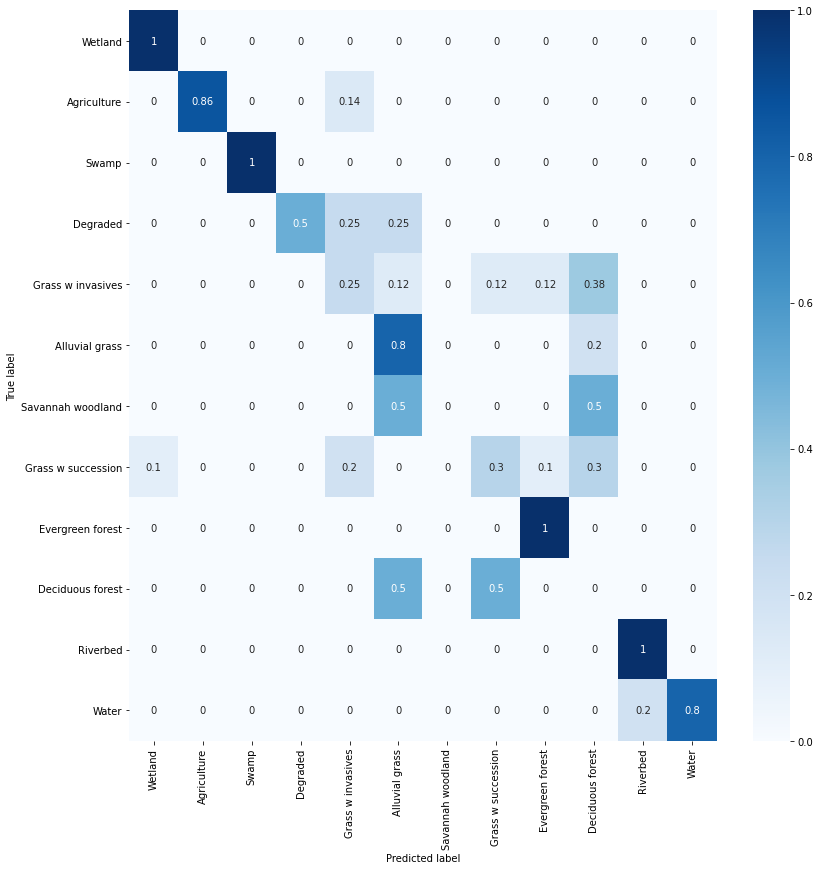

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
labels = [
          'Wetland',
          'Agriculture',
          'Swamp',
          'Degraded',
          'Grass w invasives',
          'Alluvial grass',
          'Savannah woodland',
          'Grass w succession',
          'Evergreen forest', 
          'Deciduous forest',
          'Riverbed', 
          'Water'
          ]
figure = plt.figure(figsize=(12, 12))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,xticklabels = labels, yticklabels = labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Prediction

In [ ]:
m = make_model()
# m.load_weights('/content/MyDrive/MyDrive/Manas/best_weights.hdf5')
m.load_weights('/content/MyDrive/MyDrive/Manas/supp19/best_weights.hdf5')

### Test images

In [ ]:
test1 = ee.Geometry.Polygon(
        [[[90.94772981215188, 26.75883517946187],
          [90.94772981215188, 26.693826699056437],
          [91.05690644789406, 26.693826699056437],
          [91.05690644789406, 26.75883517946187]]], None, False)

In [ ]:
task = ee.batch.Export.image.toCloudStorage(
  image= seasons18,
  description= 'manas_test1_2018',
  bucket= 'cvod-203614-mlengine',
  fileNamePrefix= 'landcover/data/predict/test1/test1_2018',
  scale= 10,
  fileFormat= 'TFRecord',
  region= test1,
  formatOptions= {
    'patchDimensions': [256, 256],
    'maxFileSize': 104857600,
    'compressed': True,
  },
)

task.start()

### Preprocessing

In [ ]:
def parse_image(example_proto):
  columns = [tf.io.FixedLenFeature(shape = KERNEL_SHAPE, dtype = tf.int64) for ft in FEATURES[:-1]]
  featuresDict = dict(zip(FEATURES[:-1], columns))
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  return parsed_features
# This input function reads in the TFRecord files exported from an image.
# Note that because the pixels are arranged in patches, we need some additional
# code to reshape the tensors.
def make_pred_dataset(fileNames):
  
  # Note that you can make one dataset from many files by specifying a list.
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
  
  dataset = dataset.map(parse_image, num_parallel_calls=5)
  
  def whatever(inputs):
    inputsList = [inputs.get(band + index) for index in ['', '_1', '_2', '_3'] for band in bands]
    inputs = tf.stack(inputsList, axis = 2)
    rescaled = tf.concat([rescale(inputs[:,:,i:i+6], 2) for i in [0,6,12,18]], axis = 2)

    return rescaled

  dataset = dataset.map(whatever, num_parallel_calls = 5)

  # Break our long tensors into many littler ones
  dataset = dataset.flat_map(lambda features: tf.data.Dataset.from_tensor_slices(features))
  dataset = dataset.flat_map(lambda features: tf.data.Dataset.from_tensor_slices(features))
  
  # Add additional features (NDVI).
  # dataset = dataset.map(addServerFeatures)
  
  # Read in batches corresponding to patch size.
  dataset = dataset.batch(PATCH_SIZE)

  return dataset

In [ ]:
predFiles19 = !gsutil ls {'gs://cvod-203614-mlengine/landcover/data/predict/test1/*2019*'}
predFile19 =  [file for file in predFiles19 if '.json' not in file ]
jsonFile19 = [file for file in predFiles19 if '.json' in file][0]

predFiles18 = !gsutil ls {'gs://cvod-203614-mlengine/landcover/data/predict/test1/*2018*'}
predFile18 =  [file for file in predFiles18 if '.json' not in file ]
jsonFile18 = [file for file in predFiles18 if '.json' in file][0]

In [ ]:
pred_dataset19 = make_pred_dataset(predFile19)
pred_dataset18 = make_pred_dataset(predFile18)

In [ ]:
iter(pred_dataset).next()

<tf.Tensor: shape=(65536, 24), dtype=float64, numpy=
array([[0.23309426, 0.14651639, 0.        , ..., 1.        , 0.51141331,
        0.08644973],
       [0.20366886, 0.13311383, 0.        , ..., 1.        , 0.40532787,
        0.04672131],
       [0.20747296, 0.14552606, 0.        , ..., 1.        , 0.41485433,
        0.04431678],
       ...,
       [0.26356589, 0.09856035, 0.03654485, ..., 1.        , 0.88361045,
        0.02731591],
       [0.29713604, 0.10023866, 0.06443914, ..., 1.        , 0.90430622,
        0.04186603],
       [0.22888617, 0.04895961, 0.        , ..., 0.90445168, 1.        ,
        0.22149837]])>

In [ ]:
def make_array_predictions(imageDataset, jsonFile):
    """Create a 3D array of prediction outputs from TFRecord dataset
    
    Given a set of TFRecords representing image patches on which to run model predictions,
    and a json file specifying the spatial reference system and arrangement of patches,
    this function writes predictions to a single, reconstructed numpy array of shape
    (?,?,2). Dimension 2 holds class probabilities and most likely class.
    
    Parameters:
        imageDataset (tf.Dataset): image patch tensors on which to run predictions
        jsonFile (str): complete filepath to json file
        kernel_buffer (tpl): pixels to trim from H, W, dimensions of each output patch
    Return:
        ndarray: 3D array of prediction outputs.
    """
    # we need metadata from the json file to reconstruct prediction patches

    # Load the contents of the mixer file to a JSON object.
    jsonText = !gsutil cat {jsonFile}
    # Get a single string w/ newlines from the IPython.utils.text.SList
    mixer = json.loads(jsonText.nlstr)
    print(mixer)
    patches = mixer['totalPatches']
    cols = mixer['patchesPerRow']
    rows = patches//cols

    # Perform inference.
    print('Running predictions...')
    predictions = m.predict(imageDataset, verbose=1)


    x = 1
    for patch in range(0, patches):
      prediction = predictions[patch*PATCH_SIZE:(patch+1)*PATCH_SIZE, :]
      predClass = np.expand_dims(np.argmax(prediction, axis = 1), axis = 1)
      stacked = np.concatenate([prediction, predClass], axis = 1)
      patch = np.reshape(stacked, newshape = (KERNEL_SIZE, KERNEL_SIZE, 13))
    # for prediction in predictions:
    #   print('Writing patch ' + str(x) + '...')
    #   predPatch = np.argmax(prediction, axis = 1)
    #   probPatch = np.max(prediction, axis = 2)
    #   predPatch = predPatch[x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]
    #   probPatch = probPatch[x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]
    #   # stack probabilities and classes along channel dimension
    #   patch = np.stack([predPatch, probPatch], axis = 2)

      ## NOTE: Predictions come out with y as 0 dimension, x as 1 dimension
      # if we're at the beginning of a row
      if x%cols == 1:
        row = patch
      else:
        row = np.append(row, patch, axis = 1)
      # if we reached the end of a row start a new one
      if x%cols == 0:
        # for the first row, create single row rows object
        if x <= cols:
          rows = row
        else:
        # add current row to previous rows along y axis
          rows = np.append(rows, row, axis = 0)
      x += 1

    return rows

In [ ]:
predArray19 = make_array_predictions(pred_dataset19, jsonFile19)
predArray18 = make_array_predictions(pred_dataset18, jsonFile18)

{'projection': {'crs': 'EPSG:4326', 'affine': {'doubleMatrix': [8.983152841195215e-05, 0.0, 90.94768515247065, 0.0, -8.983152841195215e-05, 26.758836020295483]}}, 'patchDimensions': [256, 256], 'patchesPerRow': 4, 'totalPatches': 8}
Running predictions...
8/8 [==============================] - 2s 120ms/step
{'projection': {'crs': 'EPSG:4326', 'affine': {'doubleMatrix': [8.983152841195215e-05, 0.0, 90.94768515247065, 0.0, -8.983152841195215e-05, 26.758836020295483]}}, 'patchDimensions': [256, 256], 'patchesPerRow': 4, 'totalPatches': 8}
Running predictions...
8/8 [==============================] - 2s 119ms/step


In [ ]:
predArray.shape

(512, 1024, 13)

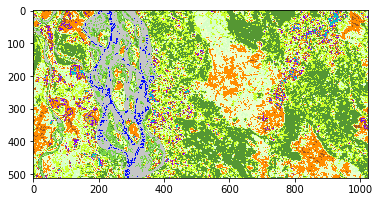

In [ ]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

cmap = colors.ListedColormap(['#02bdc6', '#dac041', '#8500ff', '#9f591d', '#ff8d00', '#eaffce', '#d7ffc6', '#caff29', '#559733', '#77d448', '#c6c6c6', '#0008ff',])
# prob = out_image[:, :, 1]
cls = predArray19[:, :, 12]
# colormap = 

plt.imshow(cls, norm = colors.BoundaryNorm([0,1,2,3,4,5,6,7,8,9,10,11,12], cmap.N), cmap = cmap)

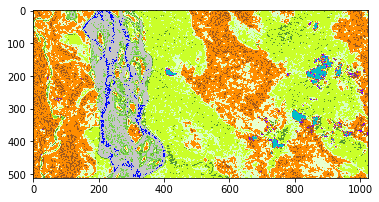

In [ ]:
cls = predArray18[:, :, 12]
plt.imshow(cls, norm = colors.BoundaryNorm([0,1,2,3,4,5,6,7,8,9,10,11,12], cmap.N), cmap = cmap)